## Analysis of FF Left Ventricle preprocessed using scanpy and SVG identification with Squidpy

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
import squidpy as sq
import csv
from sklearn.metrics.pairwise import cosine_distances

In [2]:
#load in data directly from 10X website
adata = sc.datasets.visium_sge('V1_Human_Heart')
adata.var_names_make_unique()
adata.obs

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGAGCGACTCCT-1,1,14,94
AAACAGCTTTCAGAAG-1,1,43,9
AAACAGGGTCTATATT-1,1,47,13
...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30
TTGTTTCCATACAACT-1,1,45,27


In [3]:
#Calculate some QC metrics for the data
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<IPython.core.display.Javascript object>


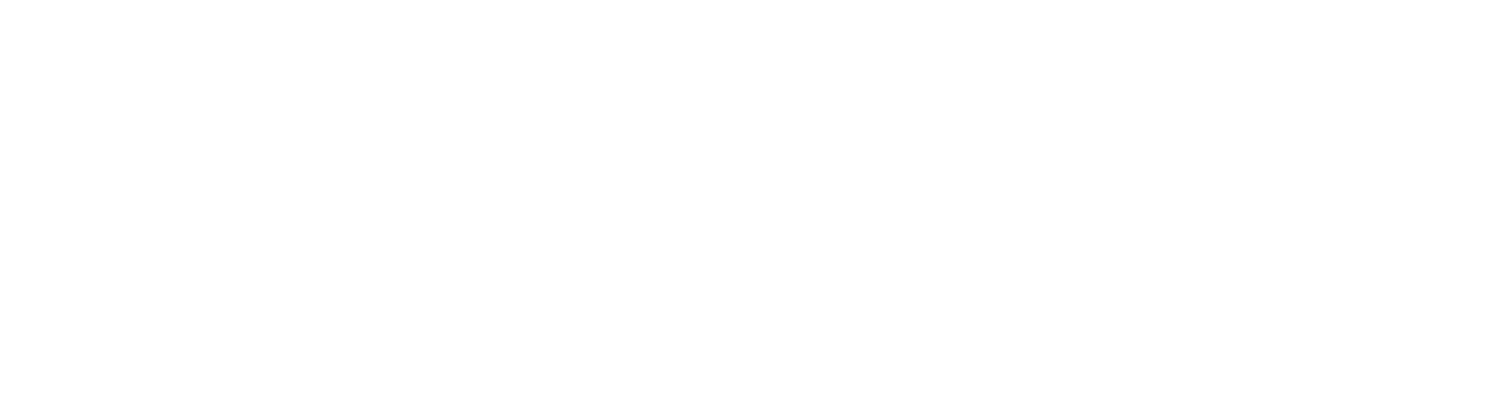

/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_63508/2890652926.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_63508/2890652926.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

<IPython.core.display.Javascript object>


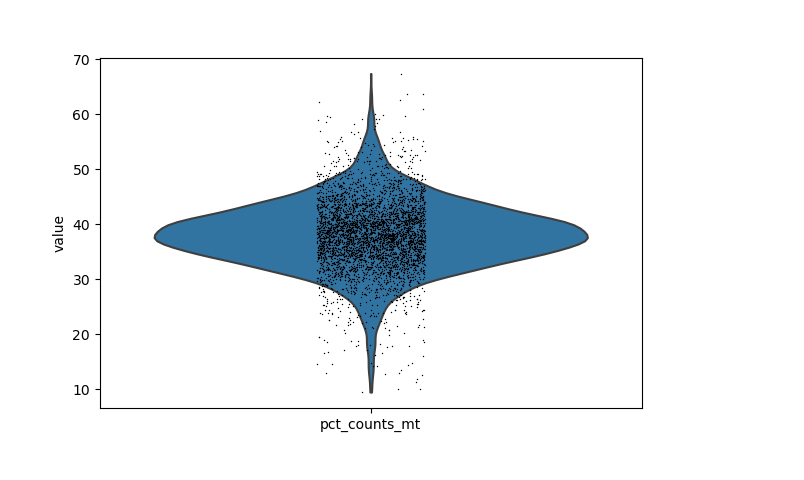

In [7]:
##Look at some basic QC metrics for the data

%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(adata,['pct_counts_mt'])

In [8]:
sc.pp.filter_cells(adata, min_counts=5000)
print(f'Number of cells after min count filter: {adata.n_obs}')
#sc.pp.filter_cells(adata, max_counts=20000)
print(f'Number of cells after max count filter: {adata.n_obs}')
adata = adata[adata.obs["pct_counts_mt"] < 60]
adata = adata[adata.obs["pct_counts_mt"] > 5]
print(f"#cells after MT filter: {adata.n_obs}")
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(adata, min_cells=10)
print(f'Number of genes after cell filter: {adata.n_vars}')
#sc.pp.filter_cells(adata, min_genes = 3000)
#print(f'Number of cells after gene filter: {adata.n_obs}')

Number of cells after min count filter: 3940
Number of cells after max count filter: 3940
#cells after MT filter: 3934


/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Number of genes after cell filter: 15127


In [9]:
adata

AnnData object with n_obs × n_vars = 3934 × 15127
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


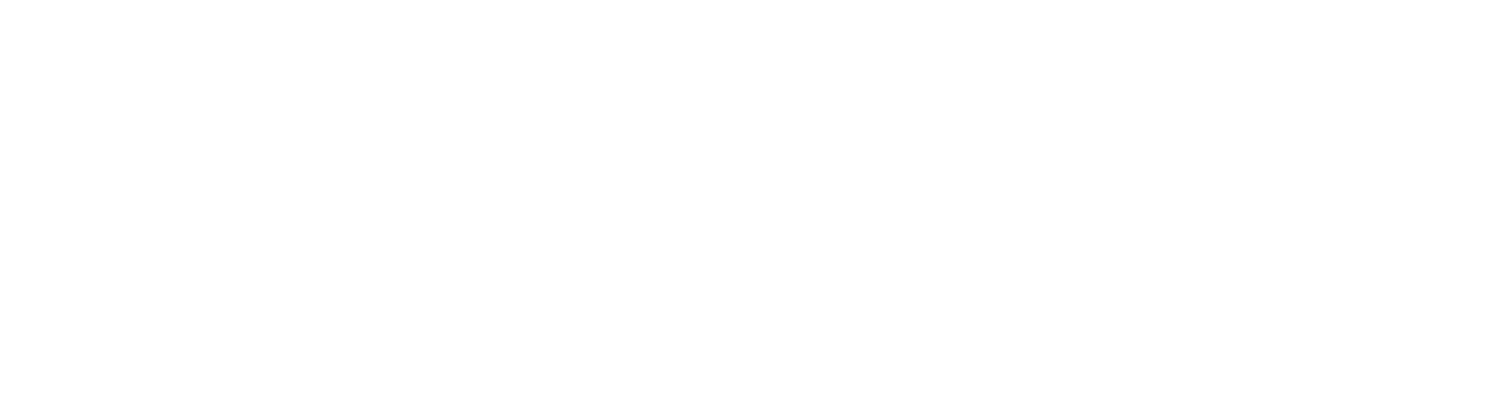

/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_63508/3716681005.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_63508/3716681005.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

<AxesSubplot: xlabel='n_genes_by_counts'>

In [11]:
#Look at distribution after normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [12]:
highly_variable_genes = pd.DataFrame(adata.var.highly_variable)
highly_variable_genes = highly_variable_genes.loc[highly_variable_genes['highly_variable'] == True]

In [13]:
#Do next step in cluster identification
sc.pp.pca(adata,n_comps=20)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='clusters')

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>


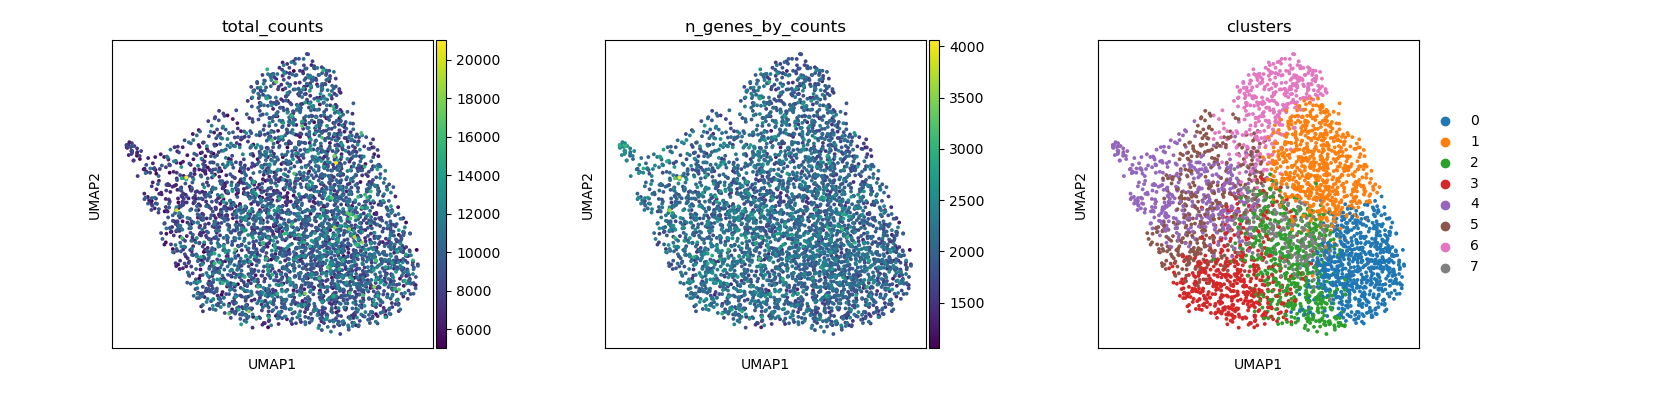

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [14]:
#Do some umap visualisations
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


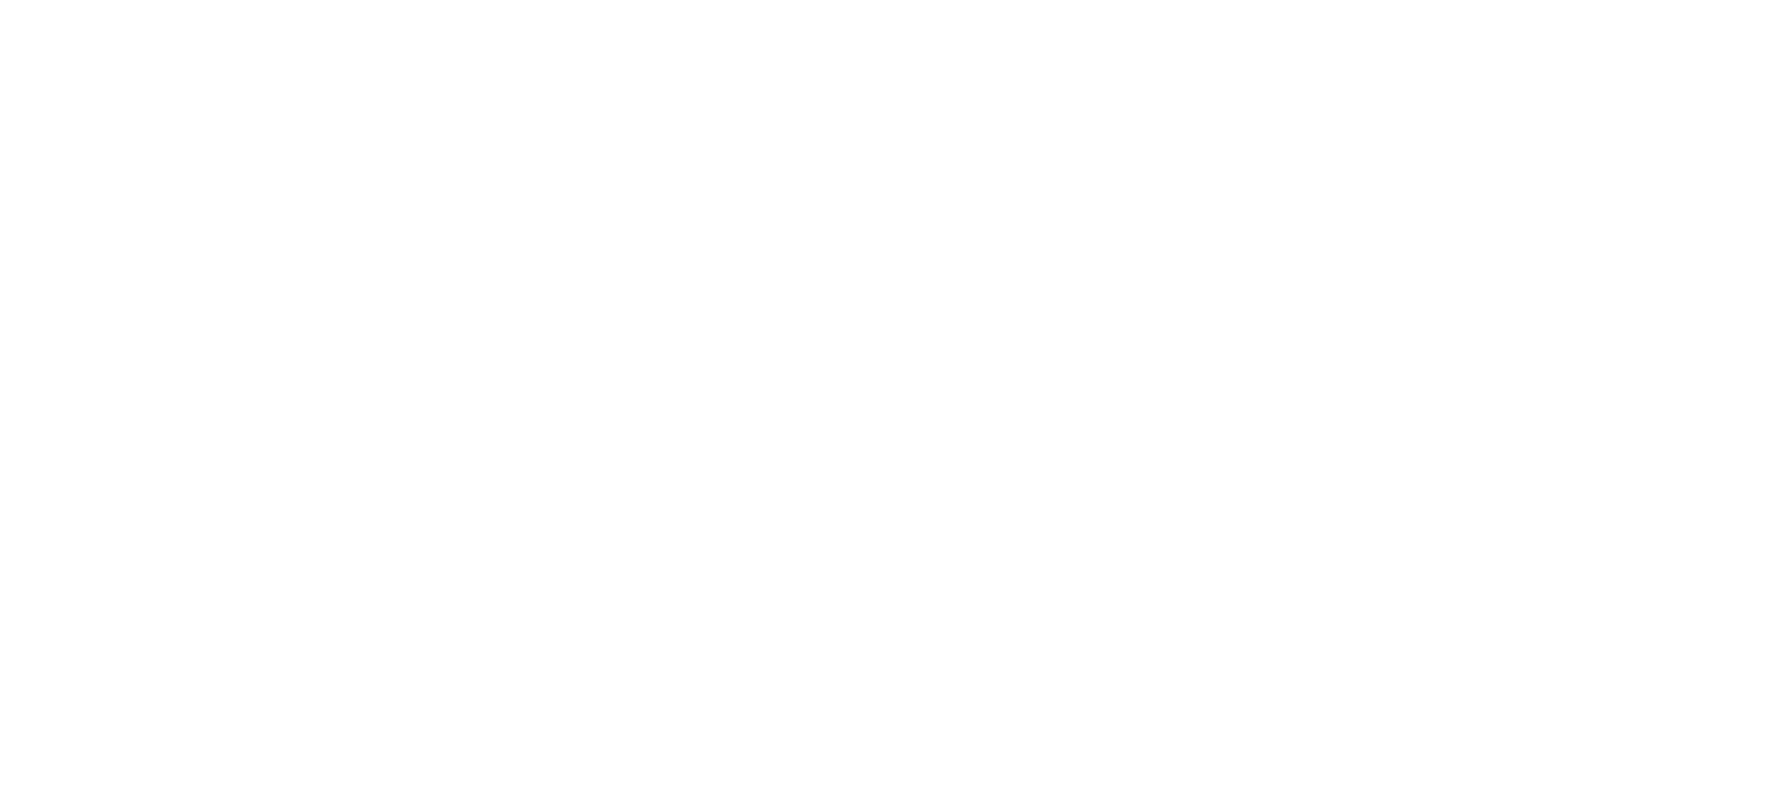

In [15]:
#Visualise in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])
#Seems like blood vessels are more visible here

<IPython.core.display.Javascript object>


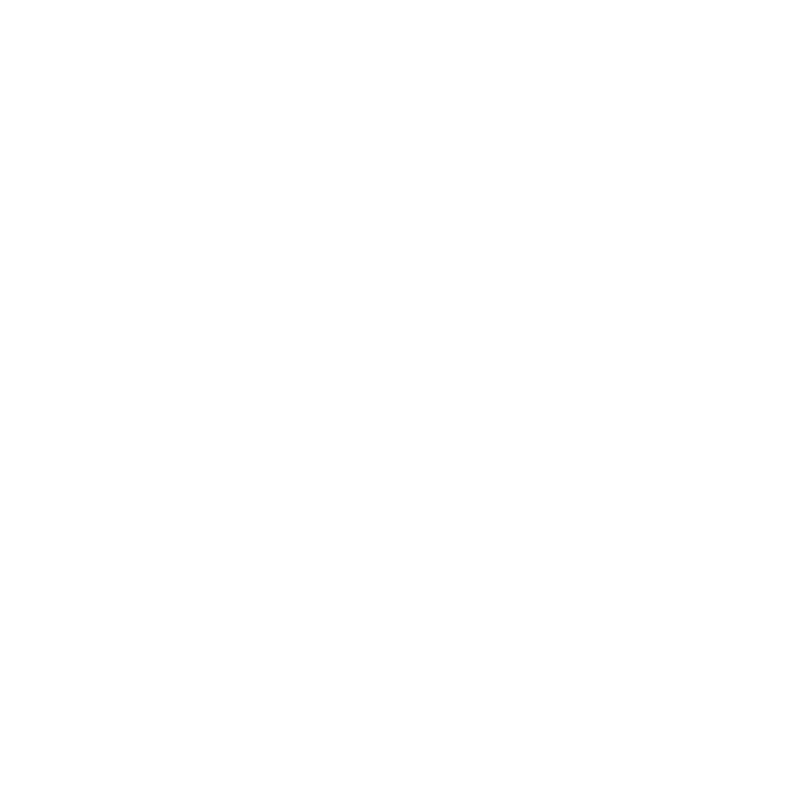

In [16]:
#Visualise cell type clusters by spatial organisation
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

categories: 0, 1, 2, etc.
var_group_labels: 5


<IPython.core.display.Javascript object>


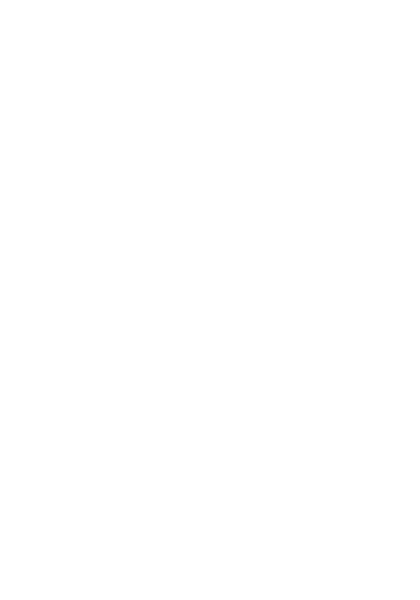

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


In [17]:
#Compute marker genes across all clusters and plot heatmap of the top 10 markers in each cluster
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="5", n_genes=10, groupby="clusters")

<IPython.core.display.Javascript object>


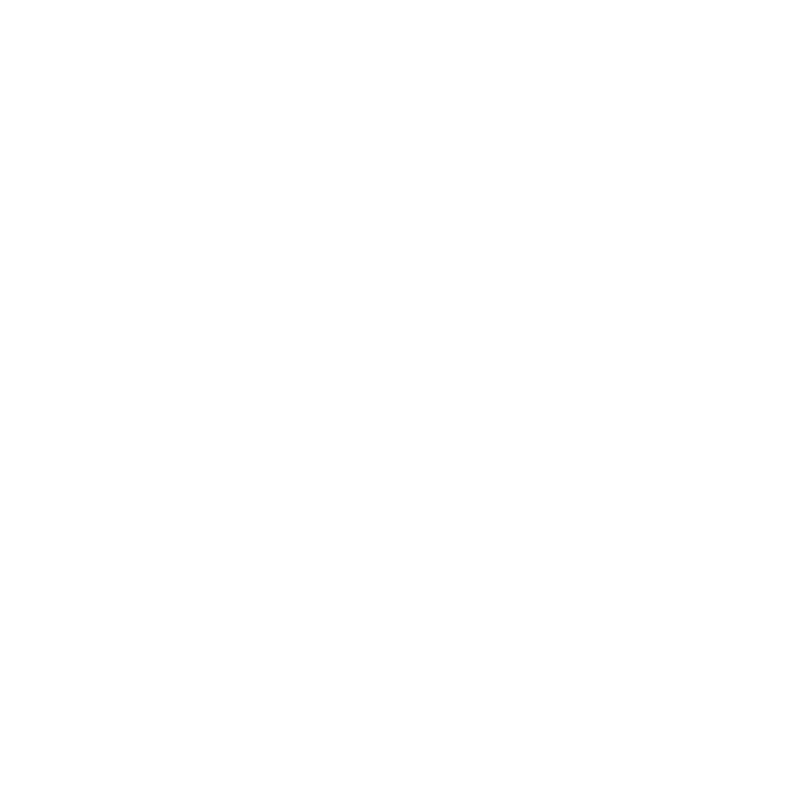

In [18]:
#Pick a gene to do a visualisation on the section - let's try c3 can fix this for presentation
#Can also do this alongside clusters
sc.pl.spatial(adata, img_key = "hires", color="C3")

### Write out files

In [ ]:
##write this AnnData object to a didfferent file format
adata.write_h5ad(filename='ff_left_ventricle.h5ad', compression=None, compression_opts=None, force_dense=None, as_dense=())

In [ ]:
#Write out normalised dataframe with expression values to file so it can be read back in for this purpose
adata.write_csvs('.',skip_data=False)

### Identify SVGs with Squidpy

In [19]:
##Run moran's I on all genes not just HVGs
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(adata, genes=adata.var_names, use_raw=False, mode="moran")
adata.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_norm_fdr_bh
ACTA1,0.424220,0.0,0.000085,0.0
MYL2,0.404866,0.0,0.000085,0.0
IGLC1,0.397587,0.0,0.000085,0.0
IGLC2,0.369950,0.0,0.000085,0.0
MT-ND4,0.367563,0.0,0.000085,0.0
FOS,0.354367,0.0,0.000085,0.0
MT-ND2,0.349715,0.0,0.000085,0.0
MT-ND3,0.348726,0.0,0.000085,0.0
MT-CO1,0.342914,0.0,0.000085,0.0
MT-CO3,0.342583,0.0,0.000085,0.0


In [ ]:
moran_I = pd.DataFrame(adata.uns['moranI'].sort_values(ascending=False,by=['I']))

##Sort this so corrected pvalue is above 0.05 and I is above 0.5
moran_I = moran_I[moran_I['pval_norm_fdr_bh'] <=0.05]

##The expected value under Moran's spatial autocorrelation is E(I) = -1/(N-1) where N is number of samples or in this case genes
moran_I = moran_I[moran_I['I'] > 0.1]
moran_I

In [21]:
##Write these out to file until figure out how to filter
moran_I.to_csv("ff_human_left_ventricle_squidpy_moranI_results_pval_fdr_bh_0.05_moransI_0.1.csv")